In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

%run preprocess.ipynb

from training_history import enable_auto_export_csv

# export setiap run ke file 'training_history.csv' (set ke 1 untuk export langsung)
enable_auto_export_csv(1, 'training_history.csv')

Step 1: Splitting data...
Loading datasets...
Found 393 files belonging to 4 classes.
Found 116 files belonging to 4 classes.
Found 69 files belonging to 4 classes.

Classes found: ['1', '2', '3', '4']
Class to PPB mapping: {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0}
Step 2: Converting labels to PPB values...
Step 3: Setting up data augmentation...
Step 4: Optimizing data pipeline...
Data preprocessing completed!


In [2]:
print("Step 5: Building ResNet-50 model...")

# Base ResNet-50 model (pre-trained on ImageNet)
base_model = ResNet50(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude top classification layer
    input_shape=(224, 224, 3)
)

# Freeze base model initially for transfer learning
base_model.trainable = False

# Build the complete model using Functional API (more stable)
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x) #mengubah 3D menjadi vektor 1D
x = layers.Dense(512, activation='relu', name='dense_512')(x)
x = layers.Dropout(0.5, name='dropout_1')(x)
x = layers.Dense(256, activation='relu', name='dense_256')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)
x = layers.Dense(64, activation='relu', name='dense_64')(x)
outputs = layers.Dense(1, activation='linear', name='aflatoxin_output')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='AflatoxinEstimator')

# Compile model for regression
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae', 'mse']
)

print("Model compiled successfully!")
print(f"Total parameters: {model.count_params():,}")

# Display model architecture
model.summary()

Step 5: Building ResNet-50 model...
Model compiled successfully!
Total parameters: 24,784,641


Model: "AflatoxinEstimator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aflatoxin_output (Dense)        │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,784,641 (94.55 MB)

 Trainable params: 1,196,929 (4.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [3]:
print("Step 6: Setting up training callbacks...")

# Training callbacks for better training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15, #jumlah epoch yg ditunggu
        restore_best_weights=True, 
        verbose=1 #menampilkan pesan di konsol saat pelatihan dihentikan
    ), # Stop training if no improvement in validation loss
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #nilai kali faktor nanti
        patience=10,
        min_lr=1e-7,
        verbose=1
    ), # Reduce learning rate if no improvement
    tf.keras.callbacks.ModelCheckpoint(
        'best_aflatoxin_resnet50.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ) # Save best model
]

Step 6: Setting up training callbacks...


In [4]:
print("Step 7: Phase 1 - Training with frozen base model...")

# Phase 1: Train with frozen base model
initial_epochs = 25

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks,
    verbose=1
)

Step 7: Phase 1 - Training with frozen base model...
Epoch 1/25


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0273 - mae: 1.7298 - mse: 4.0273
Epoch 1: val_loss improved from None to 0.73273, saving model to best_aflatoxin_resnet50.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 2.6795 - mae: 1.3322 - mse: 2.6795 - val_loss: 0.7327 - val_mae: 0.6651 - val_mse: 0.7327 - learning_rate: 1.0000e-04
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.2246 - mae: 0.9093 - mse: 1.2246
Epoch 2: val_loss did not improve from 0.73273
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 1.2328 - mae: 0.8952 - mse: 1.2328 - val_loss: 0.7448 - val_mae: 0.6949 - val_mse: 0.7448 - learning_rate: 1.0000e-04
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.9961 - mae: 0.8050 - mse: 0.9961
Epoch 3: val_loss did not improve from 0.73273
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.0360 - mae: 0.8216 - mse: 1.0360 - val_loss: 0.8011 - val_mae: 0.7051 - val_mse: 0.8011 - learning_rate: 1.0000e-04
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - 

In [6]:
print("Step 8: Phase 2 - Fine-tuning...")

# Phase 2: Fine-tuning
# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards (keep early layers frozen)
fine_tune_at = 140  # Unfreeze top layers only

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfreezing {len(base_model.layers) - fine_tune_at} layers for fine-tuning")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='mse',
    metrics=['mae', 'mse']
)

# Continue training with fine-tuning
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    callbacks=callbacks,
    verbose=1
)

Step 8: Phase 2 - Fine-tuning...
Unfreezing 35 layers for fine-tuning
Epoch 26/55
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.0694 - mae: 1.1419 - mse: 2.0694
Epoch 26: val_loss improved from 0.73273 to 0.73094, saving model to best_aflatoxin_resnet50.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 1.4772 - mae: 0.9566 - mse: 1.4772 - val_loss: 0.7309 - val_mae: 0.6563 - val_mse: 0.7309 - learning_rate: 1.0000e-05
Epoch 27/55
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0491 - mae: 0.8289 - mse: 1.0491
Epoch 27: val_loss did not improve from 0.73094
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 1.0272 - mae: 0.8097 - mse: 1.0272 - val_loss: 0.7356 - val_mae: 0.6197 - val_mse: 0.7356 - learning_rate: 1.0000e-05
Epoch 28/55
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.9441 - mae: 0.7682 - mse: 0.9441
Epoch 28: val_loss did not improve from 0.73094
13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - loss: 0.9315 - mae: 0.7673 - mse: 0.9315 - val_loss: 0.7685 - val_mae: 0.6732 - val_m

In [7]:
print("Step 9: Combining training histories...")

# Combine training histories from both phases
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

history_combined = combine_histories(history_1, history_2)

Step 9: Combining training histories...


Step 10: Plotting training history...


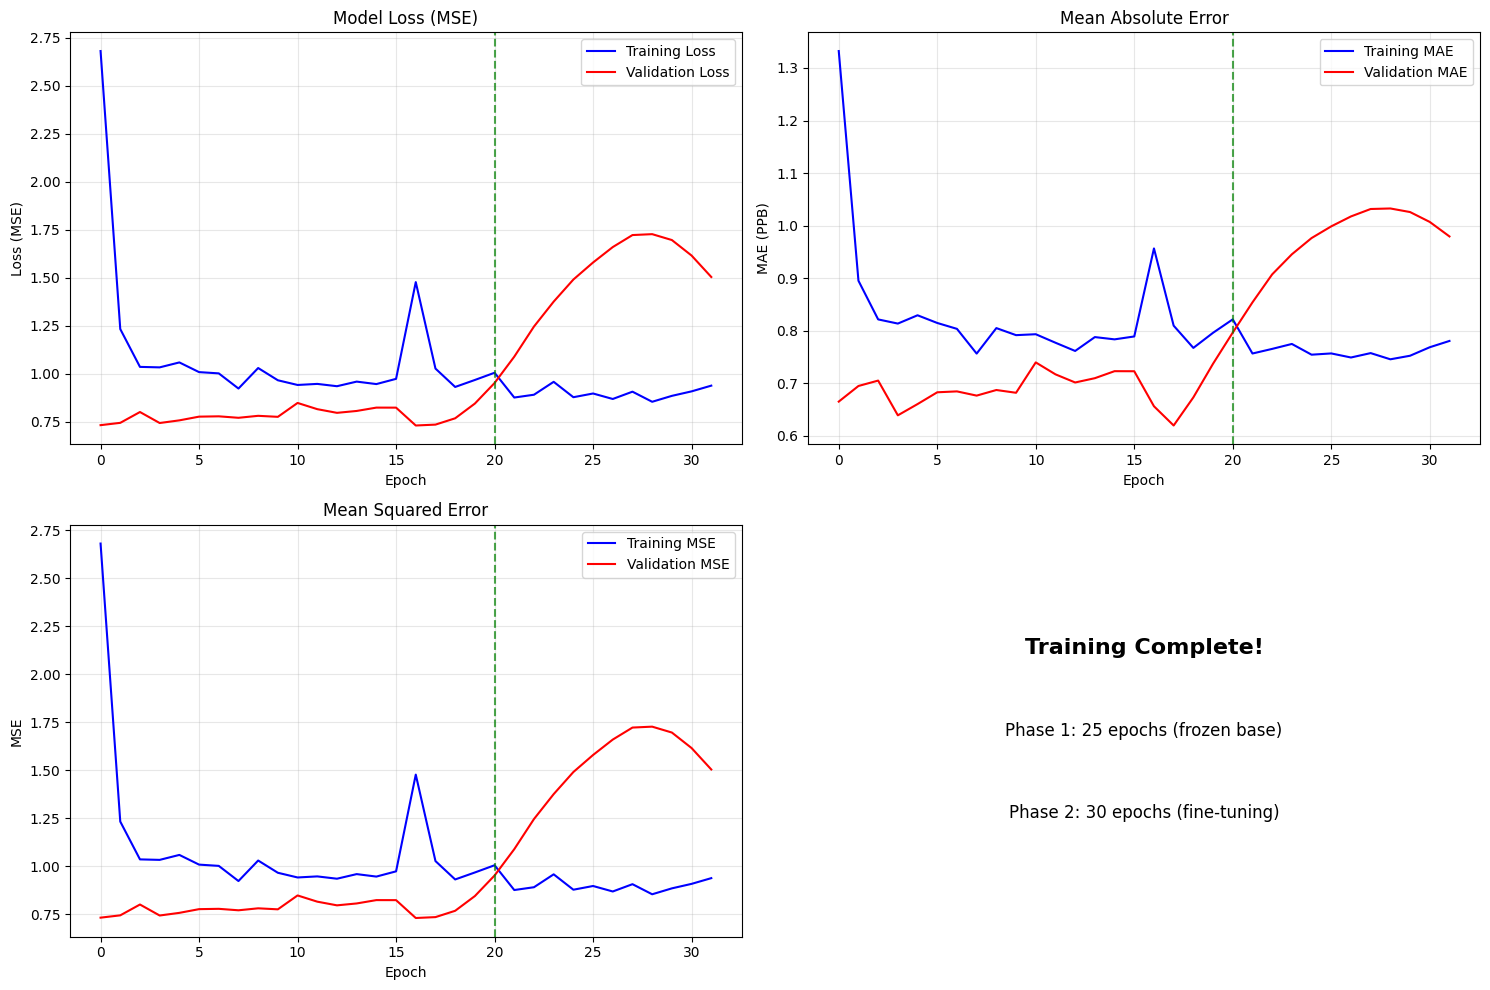

In [8]:
print("Step 10: Plotting training history...")

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0, 0].plot(history['loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss (MSE)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add phase separator
    axes[0, 0].axvline(x=20, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
    
    # MAE plot
    axes[0, 1].plot(history['mae'], label='Training MAE', color='blue')
    axes[0, 1].plot(history['val_mae'], label='Validation MAE', color='red')
    axes[0, 1].set_title('Mean Absolute Error')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE (PPB)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(x=20, color='green', linestyle='--', alpha=0.7)
    
    # MSE plot
    axes[1, 0].plot(history['mse'], label='Training MSE', color='blue')
    axes[1, 0].plot(history['val_mse'], label='Validation MSE', color='red')
    axes[1, 0].set_title('Mean Squared Error')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(x=20, color='green', linestyle='--', alpha=0.7)
    
    # Training summary
    axes[1, 1].text(0.5, 0.7, 'Training Complete!', 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axes[1, 1].transAxes, fontsize=16, fontweight='bold')
    axes[1, 1].text(0.5, 0.5, f'Phase 1: {initial_epochs} epochs (frozen base)', 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].text(0.5, 0.3, f'Phase 2: {fine_tune_epochs} epochs (fine-tuning)', 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_combined)

INGAT!!!
training loss dan validation loss yang diharapkan keduanya mendekati 0.

In [9]:
print("Step 11: Evaluating model on test set...")

# Evaluate model on test set
# Get predictions and true values
y_true = []
y_pred = []

print("Making predictions on test set...")
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(predictions.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae:.3f} PPB")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} PPB")
print(f"R² Score: {r2:.3f}")

# Classification into risk categories
def classify_risk(ppb_value):
    if ppb_value <= 75:
        return "Rendah (0-75 PPB)"
    elif ppb_value <= 150:
        return "Sedang (76-150 PPB)"
    else:
        return "Tinggi (151-200 PPB)"

# Apply risk classification
y_true_class = [classify_risk(val) for val in y_true]
y_pred_class = [classify_risk(val) for val in y_pred]

# Calculate classification accuracy
correct = sum(1 for true, pred in zip(y_true_class, y_pred_class) if true == pred)
accuracy = correct / len(y_true_class)

print(f"Risk Classification Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

# Show classification distribution
from collections import Counter
true_dist = Counter(y_true_class)
pred_dist = Counter(y_pred_class)

print("\nRisk Category Distribution:")
print("Actual:", dict(true_dist))
print("Predicted:", dict(pred_dist))

Step 11: Evaluating model on test set...
Making predictions on test set...
FINAL TEST RESULTS
Mean Absolute Error (MAE): 0.679 PPB
Mean Squared Error (MSE): 0.775
Root Mean Squared Error (RMSE): 0.880 PPB
R² Score: -0.000
Risk Classification Accuracy: 1.000 (100.0%)

Risk Category Distribution:
Actual: {'Rendah (0-75 PPB)': 69}
Predicted: {'Rendah (0-75 PPB)': 69}


Step 12: Plotting prediction results...


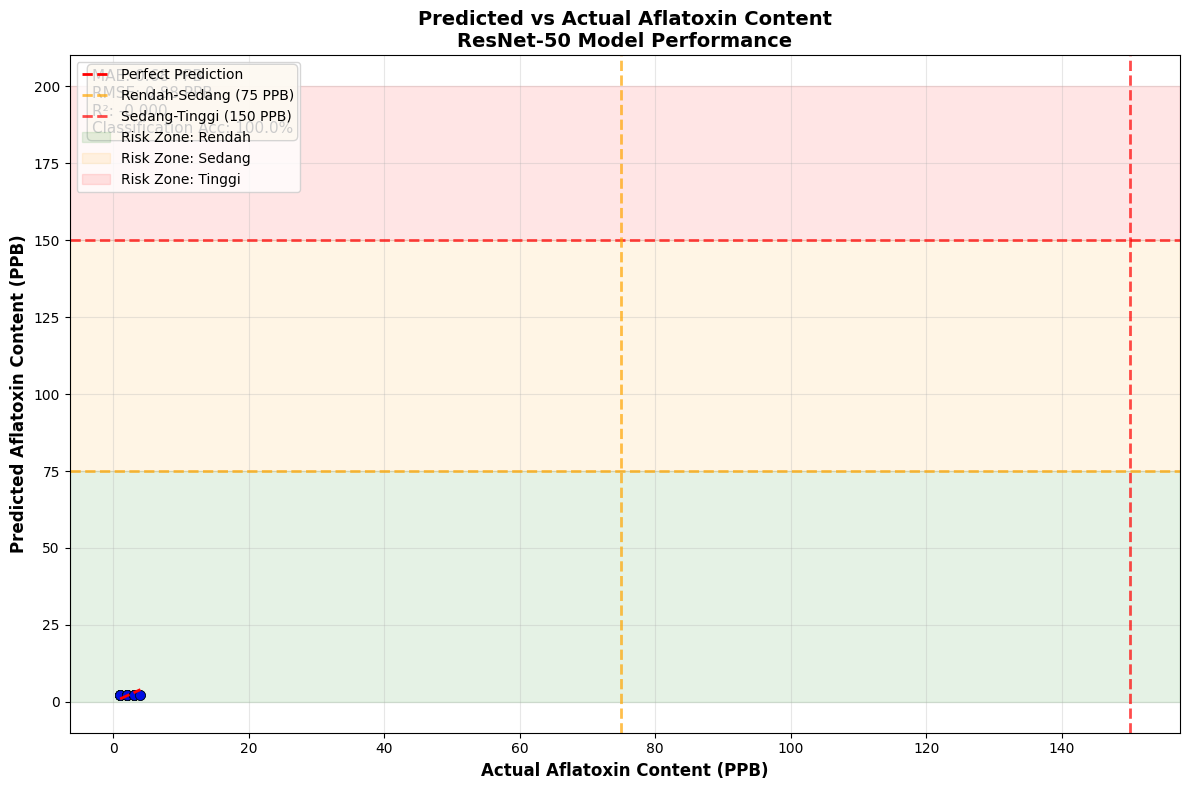

In [10]:
print("Step 12: Plotting prediction results...")

# Plot predictions vs actual values
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.6, s=50, color='blue', edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Risk category boundaries
    plt.axhline(y=75, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Rendah-Sedang (75 PPB)')
    plt.axhline(y=150, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Sedang-Tinggi (150 PPB)')
    plt.axvline(x=75, color='orange', linestyle='--', alpha=0.7, linewidth=2)
    plt.axvline(x=150, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Background colors for risk zones
    plt.axhspan(0, 75, alpha=0.1, color='green', label='Risk Zone: Rendah')
    plt.axhspan(75, 150, alpha=0.1, color='orange', label='Risk Zone: Sedang')
    plt.axhspan(150, 200, alpha=0.1, color='red', label='Risk Zone: Tinggi')
    
    plt.xlabel('Actual Aflatoxin Content (PPB)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Aflatoxin Content (PPB)', fontsize=12, fontweight='bold')
    plt.title('Predicted vs Actual Aflatoxin Content\nResNet-50 Model Performance', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add metrics text box
    textstr = f'MAE: {mae:.2f} PPB\nRMSE: {rmse:.2f} PPB\nR²: {r2:.3f}\nClassification Acc: {accuracy:.1%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

plot_predictions(y_true, y_pred)


In [ ]:
print("Step 13: Saving models and logging run history...")

# Save final model (complete model), and weights separately
final_model_path = 'aflatoxin_resnet50_final.keras'
weights_path = 'aflatoxin_resnet50_weights.weights.h5'
best_model_path = 'best_aflatoxin_resnet50.keras'

model.save(final_model_path)
print(f'\u2705 Final model saved as "{final_model_path}"')

model.save_weights(weights_path)
print(f'\u2705 Model weights saved as "{weights_path}"')

# Prepare parameters and metrics to be logged.
# You can extend `params` with any hyperparameters you change before training (learning rate, dropouts, epochs, etc.)
params = {
    'initial_epochs': initial_epochs,
    'fine_tune_epochs': fine_tune_epochs,
    'total_epochs': total_epochs,
    'fine_tune_at': fine_tune_at,
    # add optimizer and lr if available from model.optimizer
    'optimizer': str(model.optimizer.__class__.__name__) if hasattr(model, 'optimizer') else None,
}

metrics = {
    'mae': float(mae),
    'mse': float(mse),
    'rmse': float(rmse),
    'r2': float(r2),
    'risk_class_accuracy': float(accuracy),
}

# Optionally include per-epoch history arrays (may be large).
# history_combined is a dict with lists for loss, val_loss, mae, val_mae, ...
history_to_log = history_combined if 'history_combined' in globals() else None

# Model paths to store in the history record
model_paths = {
    'final': final_model_path,
    'weights': weights_path,
    'best': best_model_path,
}

# Append run record to persistent history file
try:
    from training_history import append_run, load_history, export_to_csv
    append_run(params=params, metrics=metrics, history=history_to_log, model_paths=model_paths)
    print("\u2705 Run appended to 'training_history.jsonl'")
    # Export immediately to CSV so the file appears right after this run
    try:
        export_to_csv('training_history.csv')
    except Exception as e2:
        print("\u26A0 Failed to export to CSV:", e2)
except Exception as e:
    print("\u26A0 Failed to append run history:", e)

print("="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final model performance:")
print(f"  - MAE: {mae:.3f} PPB")
print(f"  - RMSE: {rmse:.3f} PPB") 
print(f"  - R\u00b2 Score: {r2:.3f}")
print(f"  - Risk Classification Accuracy: {accuracy:.1%}")
print("="*60)


Step 13: Saving models and logging run history...
✅ Final model saved as "aflatoxin_resnet50_final.keras"
✅ Model weights saved as "aflatoxin_resnet50_weights.weights.h5"
✅ Run appended to 'training_history.jsonl'
TRAINING COMPLETED SUCCESSFULLY!
Final model performance:
  - MAE: 0.679 PPB
  - RMSE: 0.880 PPB
  - R² Score: -0.000
  - Risk Classification Accuracy: 100.0%
